In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
from matplotlib import pyplot as plt
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [183]:
from dataset import Dataset
from models import UNet
from Trainer import Trainer
from utils import accuracy
from utils import save_predictions_as_imgs
from utils import hard_dice
from utils import DiceLoss
from utils import make_blending

In [90]:
train_folder = 'train'
batch_size = 1
device = 'cuda'

train_transforms = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Rotate(limit=10, p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, p=1.0),
        #A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0, p=1),
        #A.ColorJitter(),
        # Это реальные среднее и дисперсия выборки, но такая нормализация не сильно помогает
        #tensor([0.8418, 0.8288, 0.8200]), tensor([0.2174, 0.2178, 0.2234]))
        #A.Normalize(mean=([0.8418, 0.8288, 0.8200]), std=([0.2174, 0.2178, 0.2234])),
        #A.Normalize(),
        ToTensorV2()
    ])

train_dataset = Dataset(train_folder, train_transforms)
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size, pin_memory=True, shuffle=True)

In [91]:
model = UNet(n_filters=16)
#criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss()
metric = {'name' : 'dice', 'func' : hard_dice}
config = {
    'lr': 1e-3,
    'epochs': 10,
    'early_stopping': 5
}
trainer = Trainer(model, criterion, metric, config)

In [92]:
trainer.fit(train_loader)

Epoch 1:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 0, loss: 0.06397780505093661,                   dice: 0.9581309773705222


Epoch 2:   5%|███▎                                                                      | 1/22 [00:00<00:03,  5.99it/s]

Epoch 1, loss: 0.03845543482086875,                   dice: 0.9746518622745167


Epoch 3:   5%|███▎                                                                      | 1/22 [00:00<00:03,  6.19it/s]

Epoch 2, loss: 0.03169445828957991,                   dice: 0.9802754575555975


Epoch 4:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 3, loss: 0.030378011139956387,                   dice: 0.9795378554951061


Epoch 5:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 4, loss: 0.036971314386887985,                   dice: 0.9682402123104442


Epoch 6:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 5, loss: 0.031049281358718872,                   dice: 0.9779694080352783


Epoch 7:   5%|███▎                                                                      | 1/22 [00:00<00:03,  6.39it/s]

Epoch 6, loss: 0.026645153760910034,                   dice: 0.9814960902387445


Epoch 8:   5%|███▎                                                                      | 1/22 [00:00<00:03,  5.66it/s]

Epoch 7, loss: 0.024167150259017944,                   dice: 0.9853502484885129


Epoch 9:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]

Epoch 8, loss: 0.0238953557881442,                   dice: 0.9843327457254584


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 22/22 [00:06<00:00,  3.38it/s]

Epoch 9, loss: 0.023933565074747257,                   dice: 0.9849080145359039


In [93]:
model.load_state_dict(torch.load(os.path.join(Trainer.CHECKPOINTS_PATH, 'weights.pth')))
save_predictions_as_imgs(train_loader, model)

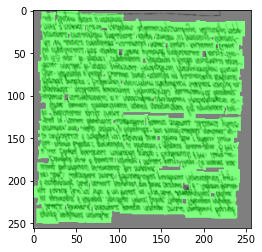

In [186]:
blend = make_blending('./saved_images/orig_3.png', './saved_images/3.png')
plt.imshow(blend)